In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
cluster_inf = pd.read_csv("cluster_inf.tsv", sep='\t')
spike_inf = pd.read_csv("spike_inf.tsv", sep='\t')

In [17]:
cluster_inf['date'].unique()

array([102522,  12123,  62323,  52423,  32323,  22423,  42422,  62322,
        72123, 112822, 122322,  30222,  72322,  82422,  42323,  52322,
        92222])

In [3]:
date_order = ['030222', '042422', '052322', '062322', '072322', '082422', 
              '092222', '102522', '112822', '122322', 
              '012123', '022423', '032323', '042323', '052423', '062323', '072123']

date_order_num = [int(i) for i in date_order]

In [4]:
waveform_mean = pd.DataFrame()
csv_files = [f for f in os.listdir('/media/ubuntu/sda/data/filter_neuron/mouse_5/natural_image/waveform') if f.startswith('waveform_mean_Neuron_') and f.endswith('.csv')]
for csv_file in csv_files:
    df = pd.read_csv(os.path.join('/media/ubuntu/sda/data/filter_neuron/mouse_5/natural_image/waveform', csv_file), index_col=0)
    waveform_mean = pd.concat((waveform_mean, df), axis=0)

waveform_mean = waveform_mean.loc[list(cluster_inf['cluster_date'])]

In [5]:
cluster_inf = cluster_inf.set_index('cluster_date')
cluster_inf = cluster_inf.join(waveform_mean, how="right")

In [23]:
spike_inf = spike_inf[spike_inf['date'] != 72322]
cluster_inf = cluster_inf[cluster_inf['date'] != 72322]

In [26]:
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

with PdfPages('figure/cluster_view.pdf') as pdf:
    for neuron in cluster_inf['Neuron'].unique():
        temp = cluster_inf[cluster_inf['Neuron'] == neuron]

        similarity = np.zeros((17, 17))
        for i in range(17):
            for j in range(17):
                similarity[i, j], _ = pearsonr(temp.iloc[i, 31:].values.astype(float), temp.iloc[j, 31:].values.astype(float))
        similarity = similarity.flatten()

        blue_palette = sns.color_palette("Blues", n_colors=17)

        fig, ax = plt.subplots(figsize=(6, 4))
        for i in range(17):
            sns.lineplot(x = range(61),
                        y = temp.iloc[i, 31:],
                        color=blue_palette[i],
                        ax=ax)
        axins = inset_axes(ax, width="20%", height="30%", loc='lower right', bbox_to_anchor=(-0.03, 0.05, 1, 1), bbox_transform=ax.transAxes)    
        sns.histplot(similarity, color='red', ax=axins, edgecolor = None)
        axins.set_yticks([])
        axins.set_ylabel("")
        axins.set_title("Similarity", fontsize=9)
        axins.tick_params(axis='both', which='major', labelsize=8)

        ax.set_ylabel("Amplitude")
        ax.set_xticks([])
        ax.set_title(neuron)
        pdf.savefig(fig)
        plt.close(fig)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.pyplot as plt

date_markers = {
    21322: 'o',
    82322: 's',
    122022: 'D',
    42323: '^'
}

unique_neurons = cluster_inf['Neuron'].unique()
palette = sns.color_palette('tab10', len(unique_neurons))
neuron_colors = {neuron: color for neuron, color in zip(unique_neurons, palette)}

with PdfPages('figure/probe_group_view.pdf') as pdf:
    for probe_group in cluster_inf['probe_group'].unique():
        temp = cluster_inf[cluster_inf['probe_group'] == probe_group]
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        for date, marker in date_markers.items():
            date_data = temp[temp['date'] == date]
            sns.scatterplot(
                x='position_1', y='position_2', hue='Neuron', style='date',
                markers={date: marker}, data=date_data, ax=ax, palette=neuron_colors, s=100
            )
        
        ax.set_title(f'Probe Group: {probe_group}')
        ax.set_xlabel('Position 1')
        ax.set_ylabel('Position 2')
        
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        ax.set_xlim(x_min, x_min + 75)
        ax.set_ylim(y_min, y_min + 125)
        
        ax.legend().remove()
        
        pdf.savefig(fig)
        plt.close(fig)

In [86]:
with PdfPages('figure/neuron_kde_view.pdf') as pdf:
    for neuron in cluster_inf['Neuron'].unique():
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'Neuron: {neuron}', fontsize=16)
        
        dates = [21322, 122022, 42323]
        titles = ['Date: 82322', 'Date: 122022', 'Date: 42323']
        for ax, date, title in zip(axes.flatten(), dates, titles):
            temp_kde = spike_inf[(spike_inf['Neuron'] == neuron) & (spike_inf['date'] == date)]
            if len(temp_kde) > 5000:
                temp_kde = temp_kde.sample(n=5000)

            sns.kdeplot(x='position_1', y='position_2', data=temp_kde, ax=ax, color='blue', fill=True)
            ax.set_title(title)
        
        temp = spike_inf[(spike_inf['Neuron'] == neuron) & (spike_inf['date'] == 21322)]
        center_x = temp['position_1'].mean()
        center_y = temp['position_2'].mean()
        mean_point = pd.DataFrame({'position_1': [center_x], 'position_2': [center_y]})  
        
        for ax in axes.flatten():
            sns.scatterplot(x='position_1', y='position_2', data=mean_point, 
                            color='black', ax=ax, s=100, marker='X') 
            ax.set_xlim(center_x - 20, center_x + 20)
            ax.set_ylim(center_y - 20, center_y + 20)
        
        pdf.savefig(fig)
        plt.close(fig)

In [6]:
trigger_time = pd.read_csv("/media/ubuntu/sda/data/mouse5/output/analysis_natural_image/01_get_trigger/trigger_time.tsv", sep = '\t').iloc[:, 1:]

In [24]:
from scipy.stats import  pearsonr
firing_rate_dict = {}
correlation_dict = {}

for date in spike_inf['date'].unique():
    spike_inf_temp = spike_inf[spike_inf['date'] == date]
    firing_rate_dict[date] = {}
    trigger_time_temp = trigger_time[trigger_time['date'] == int(date)]
    for image in trigger_time_temp['image'].unique():
        firing_rate_dict[date][image] = pd.DataFrame()
        trigger_time_temp_temp = trigger_time_temp[trigger_time_temp['image'] == image]
        for image_order in trigger_time_temp_temp['order'].sort_index().values.tolist():
            trigger_time_temp_temp_temp = trigger_time_temp_temp[trigger_time_temp_temp['order'] == image_order]
            temp = spike_inf_temp[(spike_inf_temp['time'] > int(trigger_time_temp_temp_temp['start'].values)) & (spike_inf_temp['time'] < int(trigger_time_temp_temp_temp['end'].values))]
            firing_rate_dict[date][image] = pd.concat((firing_rate_dict[date][image], pd.DataFrame(temp['Neuron'].value_counts()).sort_index()), axis=1)
        firing_rate_dict[date][image] = firing_rate_dict[date][image].fillna(0)

    correlation_dict[date] = {}
    for key in sorted(list(firing_rate_dict[date].keys())):
        num = firing_rate_dict[date][key].shape[1]
        correlation_dict[date][key] = np.zeros((num, num))
        for i in range(num):
            for j in range(num):
                correlation_dict[date][key][i, j], _ = pearsonr(firing_rate_dict[date][key].iloc[:, i].values.tolist(), firing_rate_dict[date][key].iloc[:, j].values.tolist())


In [25]:
outlier = []
for date in correlation_dict.keys():
    for image in range(1, 118):
        mean = (correlation_dict[date][image].sum(axis = 0)-1)/(len(correlation_dict[date][image]) - 1)
        for i in range(len(mean)):
            if mean[i] <= 0.6:
                outlier.append(f'{date}_{image}_{i}')

In [26]:
len(outlier)

3448

In [27]:
import pickle
with open('outlier.pkl', 'wb') as f:
    pickle.dump(outlier, f)

In [14]:
correlation_mean = pd.DataFrame()
for date in correlation_dict.keys():
    temp = []
    for image, df in correlation_dict[date].items():
        df = df.mean().mean()
        temp.append(df)
    correlation_mean = pd.concat((correlation_mean, pd.DataFrame(temp, columns=[date])),axis=1)

correlation_mean = correlation_mean[date_order_num]

In [16]:
with PdfPages("figure/similarity_within_dates.pdf") as pdf:
    mean = correlation_mean.mean(axis=0)
    std = correlation_mean.std(axis=0)

    plt.figure(figsize=(6, 3))
    sns.lineplot(x = range(20),
                 y = mean,
                 color = 'black')
    sns.scatterplot(x = range(20),
                    y = mean,
                    size=30,
                    color = "black",
                    legend=False)
    plt.fill_between(x  = range(20), 
                     y1=mean - std,
                     y2=mean + std,
                     color = 'grey',
                     alpha = 0.2)
    plt.xticks([])
    plt.ylim(0, 1)
    plt.yticks([])
    pdf.savefig()
    plt.close()

In [ ]:
with PdfPages('figure/ER_similarity_tight.pdf') as pdf:
    for date in spike_inf['date'].unique():
        fig, axes = plt.subplots(9, 13, figsize=(26, 18))  
        axes = axes.flatten()  
        
        for key in sorted(list(firing_rate_dict[date].keys())):
            ax = axes[key-1]
            sns.heatmap(correlation_dict[date][key], cmap="coolwarm", vmax=1, vmin=0, ax=ax,cbar=False, xticklabels=False, yticklabels=False)
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(0.25)  
                spine.set_color('black')

        fig.suptitle(date, fontsize=30)
        fig.subplots_adjust(wspace=0, hspace=0)

        pdf.savefig(fig)
        plt.close(fig)

In [ ]:
mean_similarity_dict = {}
for date in spike_inf['date'].unique():
    mean_similarity_dict[date] = {}
    for key in sorted(list(firing_rate_dict[date].keys())):
        mean_similarity = np.mean(correlation_dict[date][key])
        mean_similarity_dict[date][key] = mean_similarity

# 将 mean_similarity_dict 转换为 DataFrame
mean_similarity_df = pd.DataFrame(mean_similarity_dict).T

# 确保 mean_similarity_df 的索引按照 date_order_num 的顺序排列
mean_similarity_df = mean_similarity_df.loc[date_order_num]
mean_similarity_df.index = date_order  # 将索引转换为字符串

# 绘制线形图
with PdfPages('figure/ER_similarity_lineplot.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for key in mean_similarity_df.columns:
        ax.plot(mean_similarity_df.index, mean_similarity_df[key], label=f'Image {key}')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Similarity')
    ax.set_title('Mean Similarity Over Time for Each Image')
    ax.set_ylim(0, 1)    
    pdf.savefig(fig)
    plt.close(fig)

In [ ]:
with PdfPages("figure/raster_overall.pdf") as pdf:
    for neuron in spike_inf['Neuron'].unique():
        neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

        fig, ax = plt.subplots(figsize = (12, 7.5))

        for index, row in trigger_time.iterrows():
            date = row['date']
            image_order = row['order']
            start = row['start'] - 5000
            end = row['end'] + 10000
            
            filtered_spikes = neuron_df[(neuron_df['date'] == date) & 
                                        (neuron_df['time'] >= start) & 
                                        (neuron_df['time'] <= end)]
            
            if not filtered_spikes.empty:
                ax.plot(filtered_spikes['time'] - start, [index] * len(filtered_spikes), marker='|', mew=1, markersize=3, ls='', color='k')

        ax.set_yticks([])
        #ax.axvspan(1 + (5000 - 1) * 0.5, 1 + (5000 - 1), color='gray', alpha=0.3)

        ax.set_xlabel('time (s)')
        ax.set_ylabel("")
        ax.set_title(f'Raster Plot for {neuron}')

        pdf.savefig(fig)
        plt.close()

In [ ]:

with PdfPages("figure/peth_lineplot_all.pdf") as pdf:
    for neuron in spike_inf['Neuron'].unique():
        print(neuron)
        plt.figure(figsize=(4, 2.5))
        spike_rates_all = np.empty((99))

        for image in range(1, 118):
            neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

            dates = trigger_time[trigger_time['image'] == image]['date'].unique()
            date_indices = np.arange(len(dates))  

            spike_rates = []
            std_rates = []

            for date in dates:
                trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
                all_spikes = []

                for index, row in trigger_time_temp.iterrows():
                    start = row['start'] - 5000 
                    end = row['end'] + 10000

                    filtered_spikes = neuron_df[(neuron_df['date'] == date) &
                                                (neuron_df['time'] >= start) &
                                                (neuron_df['time'] <= end)]

                    if not filtered_spikes.empty:
                        relative_spikes = filtered_spikes['time'] - start
                        all_spikes.extend(relative_spikes)

                if all_spikes:
                    time_bins = np.linspace(0, max(all_spikes), 100)
                    spike_counts, _ = np.histogram(all_spikes, bins=time_bins)
                    spike_rate = spike_counts / (time_bins[1] - time_bins[0])
                    spike_rates.append(spike_rate)
                spike_rates_all = np.vstack((spike_rates_all, spike_rates))

        mean_spike_rate = np.mean(spike_rates, axis=0)
        std_spike_rate = np.std(spike_rates, axis=0)

        plt.plot(time_bins[:-1], mean_spike_rate, color='k', linewidth = 2)
        plt.plot(time_bins[:-1], mean_spike_rate - std_spike_rate, color='lightgray', alpha=0.7, linewidth = 1)
        plt.plot(time_bins[:-1], mean_spike_rate + std_spike_rate, color='lightgray', alpha=0.7, linewidth = 1)
        plt.title(neuron)
        plt.xticks([])
        plt.yticks([])
        pdf.savefig()
        plt.close()

Neuron_20
Neuron_22
Neuron_3
Neuron_17
Neuron_8
Neuron_2
Neuron_13
Neuron_14
Neuron_6
Neuron_7
Neuron_1
Neuron_10
Neuron_19
Neuron_5
Neuron_11
Neuron_18
Neuron_21
Neuron_12
Neuron_15
Neuron_4
Neuron_16
Neuron_9


In [ ]:
mean_spike_rate_dict = {}

with PdfPages("figure/peth_lineplot.pdf") as pdf:
    for image in range(1, 118):
        fig, axes = plt.subplots(4, 6, figsize=(30, 16))
        axes = axes.flatten()
        num = 0
        image_mean_spike_rate_data = []
        for neuron in spike_inf['Neuron'].unique():
            ax = axes[num]
            neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

            dates = trigger_time[trigger_time['image'] == image]['date'].unique()
            date_indices = np.arange(len(dates))  

            spike_rates = []
            std_rates = []

            for date in dates:
                trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
                all_spikes = []

                for index, row in trigger_time_temp.iterrows():
                    start = row['start'] - 5000
                    end = row['end'] + 10000

                    filtered_spikes = neuron_df[(neuron_df['date'] == date) &
                                                (neuron_df['time'] >= start) &
                                                (neuron_df['time'] <= end)]

                    if not filtered_spikes.empty:
                        relative_spikes = filtered_spikes['time'] - start
                        all_spikes.extend(relative_spikes)

                if all_spikes:
                    time_bins = np.linspace(0, max(all_spikes), 100)
                    spike_counts, _ = np.histogram(all_spikes, bins=time_bins)
                    spike_rate = spike_counts / (time_bins[1] - time_bins[0])
                    spike_rates.append(spike_rate)

            mean_spike_rate = np.mean(spike_rates, axis=0)
            std_spike_rate = np.std(spike_rates, axis=0)

            image_mean_spike_rate_data.append({
                'Neuron': neuron,
                'Mean_Spike_Rate': mean_spike_rate
            })

            ax.plot(time_bins[:-1], mean_spike_rate, color='k', linewidth = 2)
            ax.plot(time_bins[:-1], mean_spike_rate - std_spike_rate, color='lightgray', alpha=0.7, linewidth = 1)
            ax.plot(time_bins[:-1], mean_spike_rate + std_spike_rate, color='lightgray', alpha=0.7, linewidth = 1)
            #ax.set_ylim(- np.mean(mean_spike_rate) , 2 *np.mean(mean_spike_rate))
            #ax.fill_between(time_bins[:-1], mean_spike_rate - std_spike_rate, mean_spike_rate + std_spike_rate, color='lightgray', alpha=0.5, label='Std Deviation')
            quarter = (time_bins[-1] - time_bins[0]) * 0.25 + time_bins[0]
            three_quarter = (time_bins[-1] - time_bins[0]) * 0.75 + time_bins[0]
            ax.annotate("", xy=(quarter, np.max(mean_spike_rate + std_spike_rate) * 0.9), xytext=(quarter, np.max(mean_spike_rate + std_spike_rate)),
                        arrowprops=dict(arrowstyle="-|>", color="black"))
            ax.annotate("", xy=(three_quarter, np.max(mean_spike_rate + std_spike_rate) * 0.9), xytext=(three_quarter, np.max(mean_spike_rate + std_spike_rate)),
                        arrowprops=dict(arrowstyle="-|>", color="black"))
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title(f'{neuron}', fontsize=10)
            ax.legend()

            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(False)
            ax.legend().set_visible(False)
            num += 1
        axes[19].axis('off')
        axes[18].axis('off')
        fig.suptitle(f"Image_{image}", fontsize=20)
        fig.text(0.5, 0.04, 'Time', ha='center', fontsize=14)
        fig.text(0.06, 0.5, 'Spike Rate (Hz)', va='center', rotation='vertical', fontsize=14)
        pdf.savefig(fig)
        plt.close()

        mean_spike_rate_dict[image] = pd.DataFrame(image_mean_spike_rate_data)

In [29]:
for i in outlier:
    date = i.split("_")[0]
    image = i.split("_")[1] + "_" + i.split("_")[2]
    trigger_time = trigger_time[~((trigger_time['date'] == int(date)) & (trigger_time['order'] == image))]

In [87]:
def get_spike_waveforms(spikes, results_dir, bfile=None, chan=None):
    """Get waveform for each spike in `spikes`, multi- or single-channel.
    
    Parameters
    ----------
    spikes : list or array-like
        Spike times (in units of samples) for the desired waveforms, from
        `spike_times.npy`.
    results_dir : str or Path
        Path to directory where Kilosort4 sorting results were saved.
    bfile : kilosort.io.BinaryFiltered; optional
        Kilosort4 data file object. By default, this will be loaded using the
        information in `ops.npy` in the saved results.
    chan : int; optional.
        Channel to use for single-channel waveforms. If not specified, all
        channels will be returned.

    Returns
    -------
    waves : np.ndarray
        Array of spike waveforms with shape `(nt, len(spikes))`.
    
    """

    from kilosort import io
    if isinstance(spikes, int):
        spikes = [spikes]

    if bfile is None:
        ops = io.load_ops(results_dir + '/ops.npy')
        bfile = io.bfile_from_ops(ops)
    whitening_mat_inv = np.load(results_dir + '/whitening_mat_inv.npy')

    waves = []
    for t in spikes:
        tmin = t - bfile.nt0min
        tmax = t + (bfile.nt - bfile.nt0min)
        w = bfile[tmin:tmax].cpu().numpy()
        if whitening_mat_inv is not None:
            w = whitening_mat_inv @ w
        if w.shape[1] == bfile.nt:
            # Don't include spikes at the start or end of the recording that
            # get truncated to fewer time points.
            waves.append(w)
    waves = np.stack(waves, axis=-1)

    if chan is not None:
        waves = waves[chan,:]
    
    bfile.close()

    return waves


In [173]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

# 预加载所有波形数据到内存（假设内存充足）
def preload_waveforms(all_cluster_inf, all_spike_inf, results_dir):
    """
    预加载所有神经元和日期的波形数据到字典
    返回结构：{(date, cluster, neuron): waveforms}
    """
    waveform_dict = {}
    
    for neuron in tqdm(all_cluster_inf['Neuron'].unique(), desc="Preloading waveforms"):
        neuron_inf = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
        
        for date in date_order:
            cluster_inf_date = neuron_inf[neuron_inf['date'] == int(date)]
            spike_inf_date = all_spike_inf[all_spike_inf['date'] == int(date)]
            
            for cluster in cluster_inf_date['cluster'].unique():
                temp = spike_inf_date[spike_inf_date['cluster'] == cluster]
                best_chan = cluster_inf_date.loc[cluster_inf_date['cluster'] == cluster, 'best_chans'].values[0]
                
                waveforms = get_spike_waveforms(
                    spikes=list(temp['time']),
                    results_dir=os.path.join(results_dir, date, "kilosort4/sorter_output"),
                    chan=best_chan
                )
                
                key = (date, cluster, neuron)
                waveform_dict[key] = waveforms
                
    return waveform_dict

def process_trigger_time(row, waveform_dict, all_cluster_inf, all_spike_inf, n_neurons=22, window_size=61):
    """
    处理单个触发时间行
    :param row: trigger_time的一行数据（包含start/end/date/order）
    :param waveform_dict: 预加载的波形字典
    :param n_neurons: 神经元总数
    :param window_size: 波形时间窗口大小
    :return: 生成的n_neuron x 5000矩阵
    """
    output_matrix = np.zeros((n_neurons, 5000), dtype=np.float32)
    
    start_time = row['start']
    end_time = row['end']
    date = row['date']
    
    for neuron_idx, neuron in enumerate(tqdm(all_cluster_inf['Neuron'].unique(), desc=f"Processing {date}_{row['order']}")):
        neuron_inf = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
        date_inf = neuron_inf[neuron_inf['date'] == int(date)]
        
        for cluster in date_inf['cluster'].unique():
            key = (date, cluster, neuron)
            if key not in waveform_dict:
                continue
                
            waveforms = waveform_dict[key]
            
            spike_times = all_spike_inf[
                (all_spike_inf['date'] == int(date)) &
                (all_spike_inf['cluster'] == cluster)
            ]['time'].values
            
            mask = (spike_times >= start_time) & (spike_times <= end_time)
            valid_indices = np.where(mask)[0]
            valid_spikes = spike_times[mask] - start_time  
            
            valid_waveforms = waveforms.T[valid_indices]  
            
            for t, wave in zip(valid_spikes, valid_waveforms):
                center_pos = int(t)
                start_idx = max(0, center_pos - window_size//2)
                end_idx = min(5000, center_pos + window_size//2 + 1)
                
                wave_start = max(0, window_size//2 - (center_pos - start_idx))
                wave_end = min(window_size, window_size//2 + (end_idx - center_pos))
                
                wave_slice = wave[wave_start:wave_end]
                
                target_length = end_idx - start_idx
                if len(wave_slice) != target_length:
                    wave_slice = wave_slice[:target_length]  
                
                output_matrix[neuron_idx, start_idx:end_idx] += wave_slice

    return output_matrix


In [ ]:
waveform_dict = preload_waveforms(cluster_inf, spike_inf, "/media/ubuntu/sda/data/sort_output/mouse6/natural_image")

Preloading waveforms: 100%|██████████| 22/22 [30:18<00:00, 82.66s/it] 


In [180]:
n_neurons = len(cluster_inf['Neuron'].unique())
    
for idx, row in trigger_time.iterrows():
    matrix = process_trigger_time(row, waveform_dict, cluster_inf, spike_inf, n_neurons)
    
    filename = f"seg/{row['date']}_{row['order']}.npy"
    np.save(filename, matrix)
    
    del matrix

Processing 102122_92_9: 100%|██████████| 22/22 [00:00<00:00, 46.13it/s]


In [30]:
trigger_time.to_csv("trigger_time.csv", index=False)

In [15]:
spike_rates_all = pd.DataFrame()

for image in range(1, 50):
    for neuron in cluster_inf['Neuron'].unique():
        neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

        dates = trigger_time[trigger_time['image'] == image]['date'].unique()
        date_indices = np.arange(len(dates))  

        spike_rates = []
        std_rates = []

        for date in dates:
            trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
            all_spikes = []

            for index, row in trigger_time_temp.iterrows():
                start = row['start'] - 5000
                end = row['end'] + 10000

                filtered_spikes = neuron_df[(neuron_df['date'] == date) &
                                            (neuron_df['time'] >= start) &
                                            (neuron_df['time'] <= end)]

                if not filtered_spikes.empty:
                    relative_spikes = filtered_spikes['time'] - start
                    all_spikes.extend(relative_spikes)

            if all_spikes:
                time_bins = np.linspace(0, max(all_spikes), 500)
                spike_counts, _ = np.histogram(all_spikes, bins=time_bins)
                spike_rate = spike_counts / (time_bins[1] - time_bins[0])
                spike_rates.append(spike_rate)

            spike_rates_all = pd.concat((spike_rates_all, pd.DataFrame(spike_rates)), axis= 0)

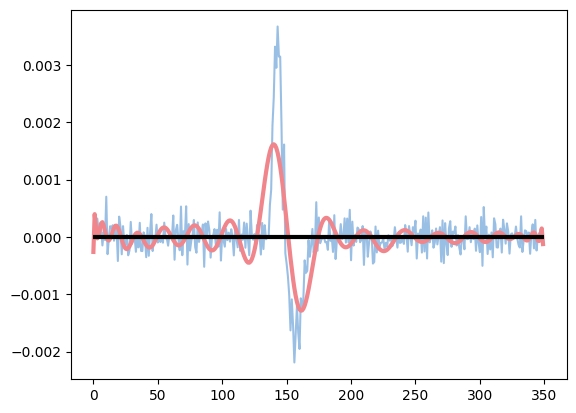

In [17]:
spike_rates_diff = np.diff(spike_rates_all, axis=1)
mean_diff = spike_rates_diff.mean(axis=0)
std_diff = spike_rates_diff.std(axis=0)

with PdfPages("figure/peth_diff.pdf") as pdf:
    from numpy.polynomial.polynomial import Polynomial
    p = Polynomial.fit(range(350), mean_diff[:350], deg=35) 

    plt.figure()
    plt.plot(range(350), mean_diff[:350], alpha=0.7, color = "#70A5D9")
    plt.plot(range(350), p(range(350)), color='#F0868C',linewidth = 3)
    plt.hlines(y = 0, xmin=0, xmax=350, colors= 'black', linewidth = 3)
    pdf.savefig()

In [25]:
roots = p.roots()[(p.roots() < 180) & (p.roots() > 115)]

In [ ]:
from scipy import stats

num_neurons = len(spike_inf['Neuron'].unique())
num_images = 117
result_matrix = np.zeros((num_neurons, num_images), dtype=int)
pvalue_matrix = np.ones((num_neurons, num_images))
diff_matrix = np.ones((num_neurons, num_images))

for image in range(1, 118):
    num = 0
    image_mean_spike_rate_data = []
    for neuron_idx, neuron in enumerate(spike_inf['Neuron'].unique()):

        neuron_df = spike_inf[spike_inf['Neuron'] == neuron]

        dates = trigger_time[trigger_time['image'] == image]['date'].unique()
        date_indices = np.arange(len(dates))  

        spike_rates_first = []
        spike_rates_second = []

        for date in dates:
            trigger_time_temp = trigger_time[(trigger_time['image'] == image) & (trigger_time['date'] == date)]
            all_spikes_first = []
            all_spikes_second = []

            for index, row in trigger_time_temp.iterrows():
                start = row['start'] + roots[0]/499 * 20000 - 5000
                end = row['end'] + roots[2]/499 * 20000 - 5000

                filtered_spikes_first = neuron_df[(neuron_df['date'] == date) &
                                                  (neuron_df['time'] >= start) &
                                                  (neuron_df['time'] <= end)]

                if not filtered_spikes_first.empty:
                    relative_spikes_first = filtered_spikes_first['time'] - start
                    all_spikes_first.extend(relative_spikes_first)

                start_2 = row['start'] -(end - start)
                end_2 = row['start'] 

                filtered_spikes_second = neuron_df[(neuron_df['date'] == date) &
                                                   (neuron_df['time'] >= start_2) &
                                                   (neuron_df['time'] <= end_2)]

                if not filtered_spikes_second.empty:
                    relative_spikes_second = filtered_spikes_second['time'] - start_2
                    all_spikes_second.extend(relative_spikes_second)

            if all_spikes_first:
                time_bins_first = np.linspace(0, max(all_spikes_first), 100)
                spike_counts_first, _ = np.histogram(all_spikes_first, bins=time_bins_first)
                spike_rate_first = spike_counts_first / (time_bins_first[1] - time_bins_first[0])
                spike_rates_first.append(spike_rate_first)

            if all_spikes_second:
                time_bins_second = np.linspace(0, max(all_spikes_second), 100)
                spike_counts_second, _ = np.histogram(all_spikes_second, bins=time_bins_second)
                spike_rate_second = spike_counts_second / (time_bins_second[1] - time_bins_second[0])
                spike_rates_second.append(spike_rate_second)

        mean_spike_rate_first = np.mean(spike_rates_first, axis=0) if spike_rates_first else np.zeros(100)
        mean_spike_rate_second = np.mean(spike_rates_second, axis=0) if spike_rates_second else np.zeros(100)

        t_stat, p_value = stats.ttest_ind(mean_spike_rate_first, mean_spike_rate_second, nan_policy='omit')

        if p_value < 0.01:
            if np.mean(mean_spike_rate_first) > np.mean(mean_spike_rate_second):
                result_matrix[neuron_idx, image-1] = 1
                diff_matrix[neuron_idx, image-1] = np.mean(mean_spike_rate_first)/np.mean(mean_spike_rate_second)
            else:
                result_matrix[neuron_idx, image-1] = -1
                diff_matrix[neuron_idx, image-1] = np.mean(mean_spike_rate_second)/np.mean(mean_spike_rate_first)
        else:
            result_matrix[neuron_idx, image-1] = 0
            diff_matrix[neuron_idx, image-1] = 1
        pvalue_matrix[neuron_idx, image-1] = p_value
        


neurons = spike_inf['Neuron'].unique()
images = range(1, 118)
result_df = pd.DataFrame(result_matrix, index=neurons, columns=images)
pvalue_df = pd.DataFrame(pvalue_matrix, index=neurons, columns=images)
diff_df = pd.DataFrame(diff_matrix, index=neurons, columns=images)

result_df.to_csv("glimpse_result_df.csv")
pvalue_df.to_csv("glimpse_pvalue_df.csv")
diff_df.to_csv("glimpse_diff_df.csv")

In [31]:
import numpy as np
import pandas as pd
import quantities as pq
from neo import SpikeTrain



def generate_binned_spiketrains(trigger_time_df, spike_inf_df, target_image):
    """
    生成指定image下的分箱脉冲矩阵
    
    参数
    ----
    trigger_time_df : pd.DataFrame
        列包括：start, end, image, date, order
    spike_inf_df : pd.DataFrame
        列包括：time, neuron, date
    target_image : str/int
        目标图像标识
    
    返回
    ----
    binned_data : list of ndarray
        [
            # Trial 1 的矩阵 (neurons × 100 bins)
            array([[n0_bin1_count, n0_bin2_count, ...],
                   [n1_bin1_count, n1_bin2_count, ...],
                   ...]),
            # Trial 2
            ...
        ]
    """
    # =====================================
    # 步骤 1: 筛选目标试次并转换时间单位
    # =====================================
    mask = (trigger_time_df['image'] == target_image)
    target_triggers = trigger_time_df[mask].sort_values('order')
    
    # 转换时间单位 (0.1ms → 秒)
    target_triggers = target_triggers.copy()
    target_triggers['start'] = target_triggers['start'] * 0.1e-3
    target_triggers['end'] = target_triggers['end'] * 0.1e-3

    # =====================================
    # 步骤 2: 处理神经脉冲数据
    # =====================================
    target_spikes = spike_inf_df.copy()
    target_spikes['time'] = target_spikes['time'] * 0.1e-3 
    
    # 获取所有唯一神经元ID并排序（基于完整数据集）
    all_neuron_ids = sorted(spike_inf_df['Neuron'].unique()) if not spike_inf_df.empty else []

    # =====================================
    # 步骤 3: 分箱处理每个试次
    # =====================================
    binned_data = []
    for _, trial in target_triggers.iterrows():
        trial_start = trial['start']
        trial_end = trial['end'] + 0.5  # 原代码的+0.5保持
        trial_duration = trial_end - trial_start
        
        spike_mask = (target_spikes['time'] >= trial_start) & (target_spikes['time'] < trial_end)
        trial_spikes = target_spikes[spike_mask].copy()
        trial_spikes['rel_time'] = trial_spikes['time'] - trial_start
        
        bin_matrix = np.zeros((len(all_neuron_ids), 20), dtype=int)
        
        neuron_groups = trial_spikes.groupby('Neuron')
        for neuron_idx, neuron_id in enumerate(all_neuron_ids):
            if neuron_id in neuron_groups.groups:
                group = neuron_groups.get_group(neuron_id)
                times = group['rel_time'].values
                
                counts, _ = np.histogram(times, bins=20, range=(0, trial_duration))
                bin_matrix[neuron_idx] = counts
                
        binned_data.append(bin_matrix)
    
    return binned_data

In [ ]:

spike_trains = {}
trajectory = {}

for date in date_order:
    for image in range(1, 118):
        num = 1

        temp = trigger_time[trigger_time['date'] == int(date)]
        temp_spike = spike_inf[spike_inf['date'] == int(date)]
        spike_train = generate_binned_spiketrains(temp, temp_spike, image)
        for i in range(len(spike_train)):
            if spike_train[i].shape[0] != 10:
                print(f'error: {date}, {image}')
                break
            np.save(f'/media/ubuntu/sda/data/filter_neuron/mouse_5/natural_image/seg_fr/{date}_{image}_{num}.npy', spike_train[i])
            num += 1

In [47]:
a = np.load("/media/ubuntu/sda/data/filter_neuron/mouse_5/natural_image/seg_fr/012123_1_1.npy")

In [48]:
a.shape

(10, 20)